# Applying Decision Tree Models to Brest Cancer Dataset

# Import modules

In [4]:
# Import the modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor


import warnings
warnings.filterwarnings("ignore")

# Data Preperation

In this demo, used the [Breast Cancer Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer). This is one of three domains provided by the Oncology Institute that has repeatedly appeared in the machine learning literature. (See also lymphography and primary-tumor.) This data set includes 201 instances of one class and 85 instances of another class. The instances are described by 9 attributes, some of which are linear and some are nominal. The data set has missing values for some attributes. I used the [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) class to handle the missing values by replacing the missing values with the frequentest item in that attribute.

In [5]:
# Loading the dataset. There are missing values (denoted as '?') in the dataset and I need to impute them.

missing_values = ["?"]
raw_data = pd.read_csv('Data/breast-cancer.csv', na_values=missing_values)
print('Missing value count: \n', raw_data.isnull().sum())

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
cancer_data = imputer.fit_transform(raw_data)

pd.DataFrame(data=cancer_data, columns=raw_data.columns).head()

Missing value count: 
 Class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
dtype: int64


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [6]:
# Data pre-processing and preparation
# Convert the date from being categorical to being numerical

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
enc_X = OrdinalEncoder()
enc_y = LabelEncoder()

# The first attribute is the target, while the rest attributes are the features

target_index=0
X = enc_X.fit_transform(cancer_data[:, 1:])
y = enc_y.fit_transform(cancer_data[:, target_index])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
# Training a decision tree model for classification
clf_default = DecisionTreeClassifier(random_state=42)
clf_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

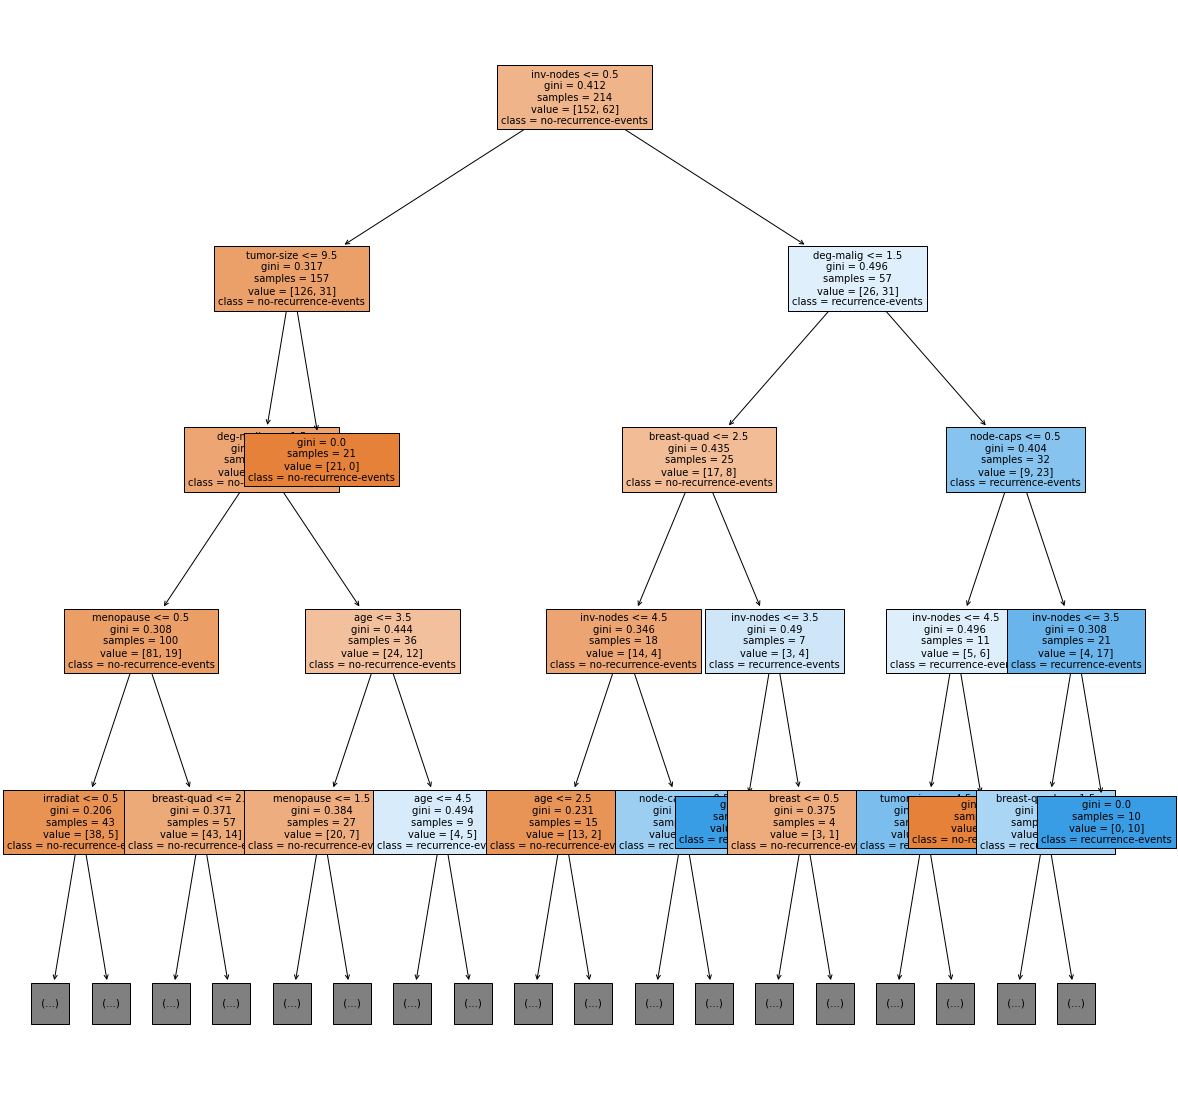

In [8]:
# Visualizing the tree structure. Shows the first four layers
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(clf_default, max_depth=4, filled=True, fontsize=10, 
               feature_names=raw_data.columns[1:], class_names=enc_y.classes_)
plt.show()

**Analysing the decision tree.** The visualization of the tree provides a great in-depth view of how the algorithm makes predictions, and is a good example of a machine learning algorithm that is easily explained to nonexperts. However, even with a tree of depth four, as seen here, the tree can become a bit overwhelming. Deeper trees (a depth of 10 is not uncommon) are even harder to grasp. One method of inspecting the tree that may be helpful is to find out which path most of the data actually takes. The samples shown in each node in the above figure gives the number of samples in that node, while value provides the number of samples per class. 

The testing accuracy is: 0.6389

[[39 16]
 [10  7]]


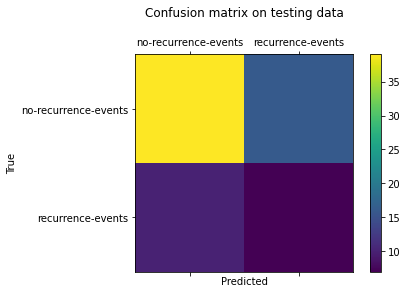

In [9]:
# Evaluating the trained model with the testing data
y_pred = clf_default.predict(X_test)

# The prediction accuracy
accuracy = accuracy_score(y_pred, y_test)
print('The testing accuracy is: %.4f\n' % accuracy)

# Showing the confusion matrix
labels = clf_default.classes_
cm = confusion_matrix(y_pred, y_test, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels(['', enc_y.inverse_transform([int(clf_default.classes_[0])])[0], enc_y.inverse_transform([int(clf_default.classes_[1])])[0]])
ax.set_yticklabels(['', enc_y.inverse_transform([int(clf_default.classes_[0])])[0], enc_y.inverse_transform([int(clf_default.classes_[1])])[0]])
plt.title('Confusion matrix on testing data\n')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# Show the importance for each feature
print("Feature importances:\n{}".format(clf_default.feature_importances_))

Feature importances:
[0.12260842 0.03929789 0.18590085 0.20248922 0.01967012 0.11976458
 0.07529919 0.17827024 0.05669949]


## Parameter tuning on splitting criterion

In [11]:
# Use 10-fold cross validation for each criterion to report the testing accuracy.
cv_scores = []
cv_scores_std = []
splitting_criteria = ['gini', 'entropy']
for i in splitting_criteria:
    clf_dtc = DecisionTreeClassifier(criterion=i, random_state=42)
    scores = cross_val_score(clf_dtc, X, y, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

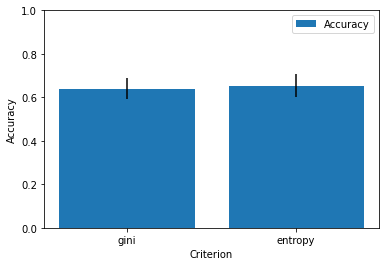

In [12]:
# Plot the relationship
plt.bar(splitting_criteria, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Criterion')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**It can be seen that the difference between these two criteria is visually significant for this data set.**

In [13]:
# Use 10-fold cross validation for each criterion to report the testing accuracy.
cv_scores = []
cv_scores_std = []
depths = range(1,21)
for i in depths:
    clf_dtc = DecisionTreeClassifier(max_depth=i, random_state=42)
    scores = cross_val_score(clf_dtc, X, y, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

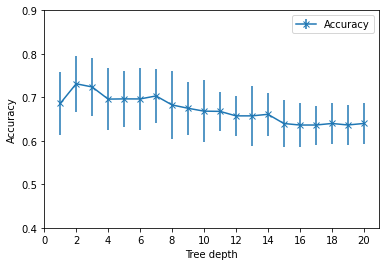

In [14]:
# Ploting the relationship
plt.errorbar(depths, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('Tree depth')
plt.xticks(np.arange(0,21,step=2))
plt.ylim(0.4, 0.9)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Decision tree for regression

In [15]:
# Generating a 1-dimensional synthetic dataset. The data is combination of two 'sin' functions and the Gausssian noise.
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(2 * X).ravel() + rng.normal(0, 0.5, X.shape[0])

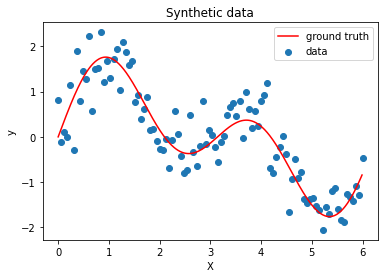

In [16]:
# Visualizing the data and the ground truth
x_truth = np.arange(0, 6, 0.01)
y_truth = np.sin(x_truth)+np.sin(2*x_truth)

plt.plot(x_truth, y_truth, color='red', label='ground truth')
plt.scatter(X, y, label='data')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic data')
plt.legend(loc='best')
plt.show()

## Training a Regression Model with Tree Depth 4

In [17]:
# Spliting data into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Training a regression tree with max_depth=4.
regressor = DecisionTreeRegressor(random_state=42, max_depth=4)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

**Visualize the tree structure**

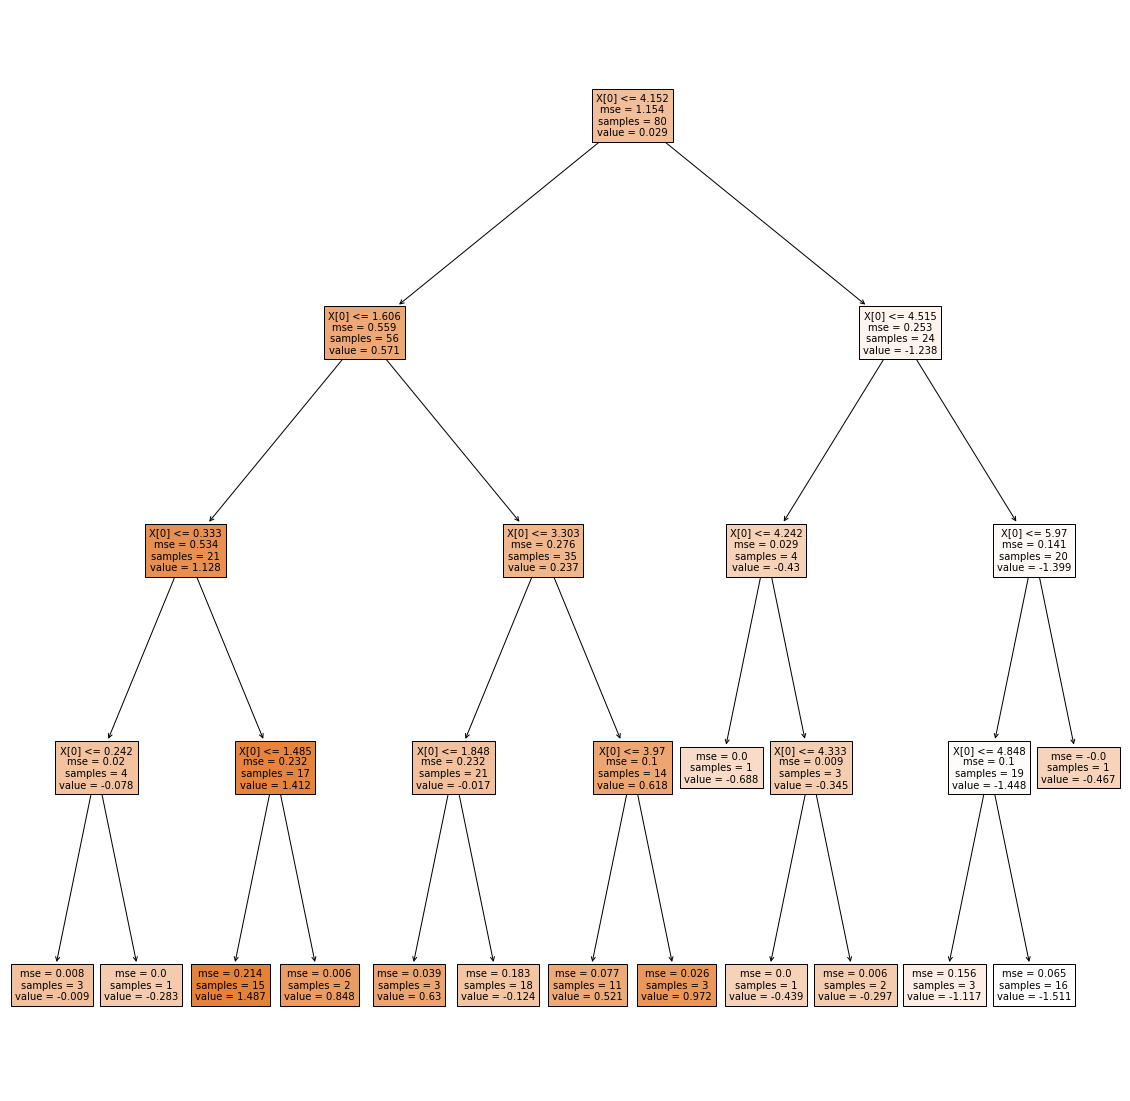

In [19]:
# Visualize the tree structure.
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(regressor, filled=True, fontsize=10)
plt.show()

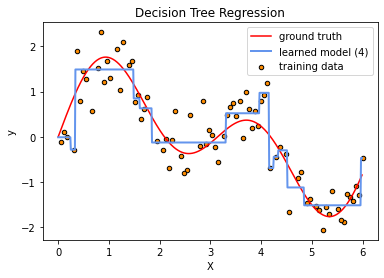

In [20]:
# Plot the learned model
x_truth = np.arange(0, 6, 0.01)
y_truth = np.sin(x_truth)+np.sin(2*x_truth)

X_model = np.arange(0.0, 6.0, 0.01)[:, np.newaxis]
y_model = regressor.predict(X_model)

plt.plot(x_truth, y_truth, color='red', label='ground truth')
plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="training data")
plt.plot(X_model, y_model, color="cornflowerblue", label="learned model (4)", linewidth=2)

plt.xlabel("X")
plt.ylabel("y")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [21]:
# Evaluate the model with the testing data
y_pred = regressor.predict(X_test)
score = r2_score(y_pred, y_test)
print("\nThe r2 score is: %.4f\n" % score)


mse_test = mean_squared_error(y_pred, y_test)
mse_train = mean_squared_error(regressor.predict(X_train), y_train)
print("The mean squared error (testing) is: %.4f\n" % mse_test)
print("The mean squared error (training) is: %.4f\n" % mse_train)


The r2 score is: 0.7653

The mean squared error (testing) is: 0.2123

The mean squared error (training) is: 0.1138



# Building a Tree Regression Model with max_depth=8

In [22]:
# Training a regression tree with max_depth=8.
regressor_a = DecisionTreeRegressor(random_state=42, max_depth=8)
regressor_a.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=42)

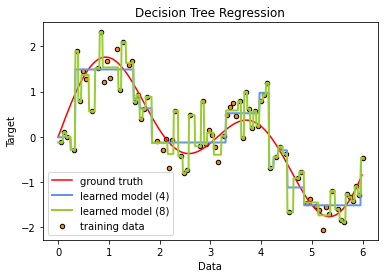

In [24]:
# Ploting the learned model, tegether with the ground truth curve, training data, and the max_depth=4 case
x_truth = np.arange(0, 6, 0.01)
y_truth = np.sin(x_truth)+np.sin(2*x_truth)

X_contour = np.arange(0.0, 6.0, 0.01)[:, np.newaxis]
y_contour = regressor.predict(X_contour)
y_contour_a = regressor_a.predict(X_contour)

plt.figure()
plt.plot(x_truth, y_truth, color='red', label='ground truth')
plt.scatter(X_train, y_train, s=20, edgecolor="black", c="darkorange", label="training data")
plt.plot(X_contour, y_contour, color="cornflowerblue", label="learned model (4)", linewidth=2)
plt.plot(X_contour, y_contour_a, color="yellowgreen", label="learned model (8)", linewidth=2)
plt.xlabel("Data")
plt.ylabel("Target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [25]:
# Evaluating the model with the testing data, using the metrics r2, testing mse, and training mse.
y_pred = regressor_a.predict(X_test)
score = r2_score(y_pred, y_test)
print("\nThe r2 score is: %.4f\n" % score)


mse_test = mean_squared_error(y_pred, y_test)
mse_train = mean_squared_error(regressor.predict(X_train), y_train)
print("The mean squared error (testing) is: %.4f\n" % mse_test)
print("The mean squared error (training) is: %.4f\n" % mse_train)


The r2 score is: 0.5921

The mean squared error (testing) is: 0.3464

The mean squared error (training) is: 0.1138

